# **Skenario 2 - CNN ResNet50**

Skenario 2 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur ResNet50 untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Impor semua pustaka dan modul yang dibutuhkan untuk pemrosesan data, visualisasi, pembuatan model, dan pelatihan model

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import KFold

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data
Load dan proses data `image_selected.npz`

In [2]:
def load_and_preprocess_data():
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Load data from npz file
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Prepare X dan Y lists
    X = []
    Y = []

    # Buat label mapping untuk tiap kelas 
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterate through loaded data
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, resized_slice = selected_slice

                # Pastikan resized_slice memiliki tiga saluran warna
                resized_slice_rgb = cv2.cvtColor(resized_slice, cv2.COLOR_GRAY2RGB)

                # Append data to X and Y
                X.append(resized_slice_rgb)
                Y.append(label_mapping[label])

    # Convert lists ke numpy arrays
    X = np.array(X) / 255.0  # Normalisasi
    Y = np.array(Y)

    # Convert labels to categorical format
    Y = to_categorical(Y, num_classes=len(set(Y)))

    return X, Y

In [3]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data()

In [4]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (7200, 224, 224, 3)
Y shape: (7200, 4)


In [5]:
unique_labels, counts = np.unique(np.argmax(Y, axis=1), return_counts=True)
class_distribution = dict(zip(tuple(unique_labels), counts))

print("Distribusi Kelas setelah One-Hot Encoding:")
print(class_distribution)

Distribusi Kelas setelah One-Hot Encoding:
{0: 1800, 1: 1800, 2: 1800, 3: 1800}


### 2.2 Pembagian Data
Data dibagi dengan rasio 80:20 

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cek shape dan jumlah data

In [7]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224, 3)
Dimensi Y_train: (5760, 4)
Dimensi X_test: (1440, 224, 224, 3)
Dimensi Y_test: (1440, 4)


In [8]:
print("Jumlah sampel dalam X_train:", len(X_train))
print("Jumlah sampel dalam Y_train:", len(Y_train))
print("Jumlah sampel dalam X_test:", len(X_test))
print("Jumlah sampel dalam Y_test:", len(Y_test))

Jumlah sampel dalam X_train: 5760
Jumlah sampel dalam Y_train: 5760
Jumlah sampel dalam X_test: 1440
Jumlah sampel dalam Y_test: 1440


## 3. Buat dan Konfigurasi Model
Arsitektur yang digunakan yaitu ResNet50 sebagai bagian dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [9]:
%%time
inputs = Input(shape=(224, 224, 3))

# Gunakan base_model sebagai lapisan dalam model Anda
base_model = ResNet50(
    weights='imagenet',
    input_tensor=inputs,  
    include_top=False
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)

# Menggabungkan input dan output untuk membuat model
model = Model(inputs, outputs)

# Menetapkan agar semua layer pada base_model tidak dapat di-train
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## 4. Training Model
Latih model dengan data `X_train dan Y_train` dan menguji kinerja model pada data validasi `X_test dan Y_test`, setelah pelatihan nanti model akan menyimpan riwayatnya ke dalam `h_model`

In [10]:
# Fine-tuning
EPOCH = 25
h_model = model.fit(X_train, Y_train, epochs=EPOCH, validation_data=(X_test, Y_test))

Epoch 1/25
180/180 [==============================] - 227s 1s/step - loss: 1.5606 - accuracy: 0.3467 - val_loss: 1.2390 - val_accuracy: 0.4257
Epoch 2/25
180/180 [==============================] - 227s 1s/step - loss: 1.1779 - accuracy: 0.4691 - val_loss: 1.1432 - val_accuracy: 0.4965
Epoch 3/25
180/180 [==============================] - 231s 1s/step - loss: 1.0676 - accuracy: 0.5394 - val_loss: 1.0669 - val_accuracy: 0.5431
Epoch 4/25
180/180 [==============================] - 232s 1s/step - loss: 0.9920 - accuracy: 0.5841 - val_loss: 1.0484 - val_accuracy: 0.5542
Epoch 5/25
180/180 [==============================] - 232s 1s/step - loss: 0.9300 - accuracy: 0.6076 - val_loss: 1.0132 - val_accuracy: 0.5681
Epoch 6/25
180/180 [==============================] - 233s 1s/step - loss: 0.8686 - accuracy: 0.6375 - val_loss: 0.9411 - val_accuracy: 0.6083
Epoch 7/25
180/180 [==============================] - 234s 1s/step - loss: 0.8019 - accuracy: 0.6807 - val_loss: 0.9142 - val_accuracy: 0.6132

## 5. Testing

### 5.1 Menilai model pada data uji

In [11]:
# Evaluasi model menggunakan data uji NumPy
evaluation_result = model.evaluate(X_test, Y_test, verbose=1)

# Menampilkan hasil evaluasi
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

# Prediksi menggunakan data uji
predictions = model.predict(X_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

print('Label Sebenarnya : ', np.argmax(Y_test, axis=1))
print('Label Prediksi : ', predicted_labels)

45/45 [==============================] - 48s 1s/step - loss: 0.6510 - accuracy: 0.7799
Loss: 0.6510413289070129
Accuracy: 0.7798610925674438
Label Sebenarnya :  [1 1 2 ... 3 1 1]
Label Prediksi :  [0 1 2 ... 3 1 0]


### 5.2 Visualisasi beberapa gambar dari data uji
Membuat visualisasi dari beberapa contoh hasil prediksi model pada data test

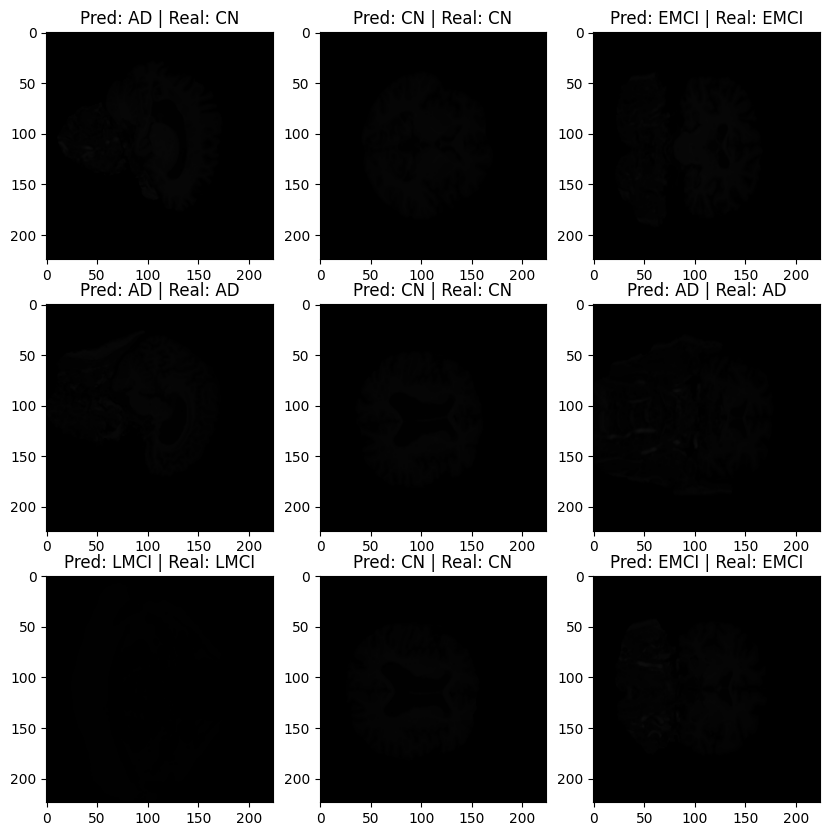

In [12]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

plt.figure(figsize=(10, 10))
for i in range(min(9, len(X_test))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].astype("uint8"))
    
    # Dapatkan label prediksi dan label sebenarnya
    true_label = np.argmax(Y_test[i])
    plt.title("Pred: " + class_names[predicted_labels[i]] + " | Real: " + class_names[true_label])

plt.show()

## 6. Evaluasi

### 6.1 Matriks specificity dan sensitivity

In [13]:
from keras import backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', specificity, sensitivity])

Evaluasi model pada data train

In [14]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_train, Y_train)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

180/180 [==============================] - 190s 1s/step - loss: 0.2039 - accuracy: 0.9274 - specificity: 0.9816 - sensitivity: 0.9139
Loss train set:  0.20719307661056519
Akurasi train set:  0.926562488079071
Specificity train set:  0.9814237952232361
Sensitivity train set:  0.9133680462837219


Evaluasi model pada data test

In [15]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_test, Y_test)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

45/45 [==============================] - 48s 1s/step - loss: 0.6510 - accuracy: 0.7799 - specificity: 0.9412 - sensitivity: 0.7521
Loss train set:  0.6510413289070129
Akurasi train set:  0.7798610925674438
Specificity train set:  0.9412037134170532
Sensitivity train set:  0.7520833611488342


Visualisasi confusion matrix

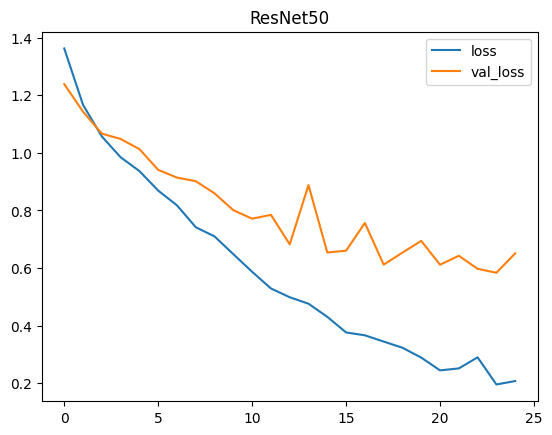

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# loss
fig, ax = plt.subplots()
ax.plot(h_model.history['loss'], label='loss')
ax.plot(h_model.history['val_loss'], label='val_loss')
ax.legend()
plt.title('ResNet50')
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\ResNet50Loss.png')

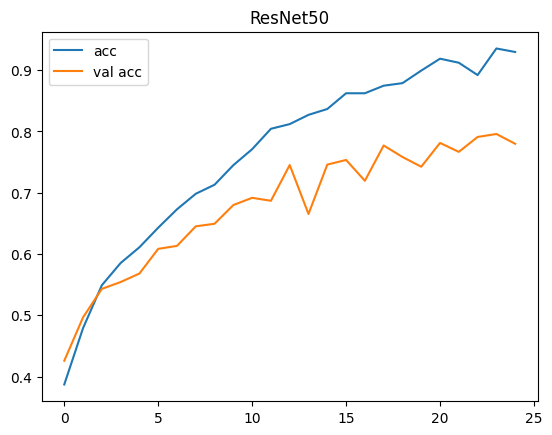

In [17]:
# accuracies
fig, ax = plt.subplots()
ax.plot(h_model.history['accuracy'], label='acc')
ax.plot(h_model.history['val_accuracy'], label='val acc')
ax.legend()
plt.title('ResNet50')
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\ResNet50Accuracy.png')

In [18]:
# Simpan model
model.save(r"D:\Users\RESA\Coding\Evaluasi\ResNet50.h5")

In [19]:
y_preds =  model.predict(X_test)
y_preds

array([[9.9063253e-01, 4.6338863e-04, 7.3112227e-04, 8.1729172e-03],
       [2.3074785e-01, 7.3062474e-01, 2.3755566e-03, 3.6251899e-02],
       [4.2639941e-02, 1.6584226e-03, 9.5529294e-01, 4.0871790e-04],
       ...,
       [8.2728468e-02, 2.5212613e-03, 1.2043893e-03, 9.1354591e-01],
       [3.4624612e-05, 9.7521055e-01, 2.1048456e-02, 3.7063418e-03],
       [8.6300963e-01, 8.2290620e-02, 3.2286692e-02, 2.2413112e-02]],
      dtype=float32)

In [20]:
y_preds_ind = np.argmax(y_preds,axis=1)
y_preds_ind

array([0, 1, 2, ..., 3, 1, 0], dtype=int64)

In [21]:
qwe=np.argmax(Y_test, axis=1)

In [22]:
confusion_matrix(qwe,y_preds_ind)

array([[340,  20,   8,  12],
       [ 47, 268,  10,  13],
       [ 40,  44, 262,  17],
       [ 44,  38,  24, 253]], dtype=int64)

In [23]:
print(classification_report(qwe,y_preds_ind))

              precision    recall  f1-score   support

           0       0.72      0.89      0.80       380
           1       0.72      0.79      0.76       338
           2       0.86      0.72      0.79       363
           3       0.86      0.70      0.77       359

    accuracy                           0.78      1440
   macro avg       0.79      0.78      0.78      1440
weighted avg       0.79      0.78      0.78      1440



In [24]:
model.evaluate(X_test, Y_test)

45/45 [==============================] - 47s 1s/step - loss: 0.6510 - accuracy: 0.7799 - specificity: 0.9412 - sensitivity: 0.7521


[0.6510413289070129,
 0.7798610925674438,
 0.9412037134170532,
 0.7520833611488342]

### 6.3 ROC AUC Curve

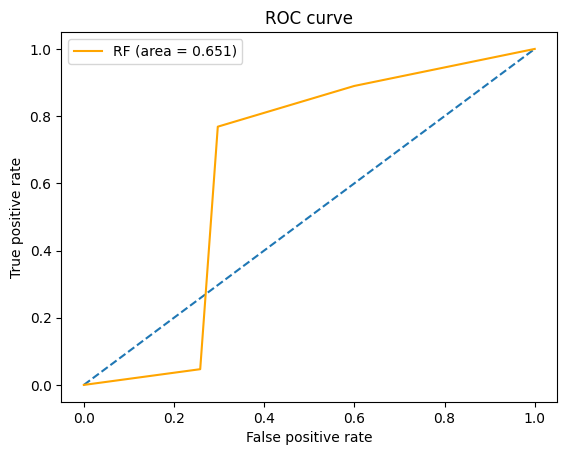

In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(qwe, y_preds_ind, pos_label=2)

auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1],"--")

plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc), color='orange')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Visualization

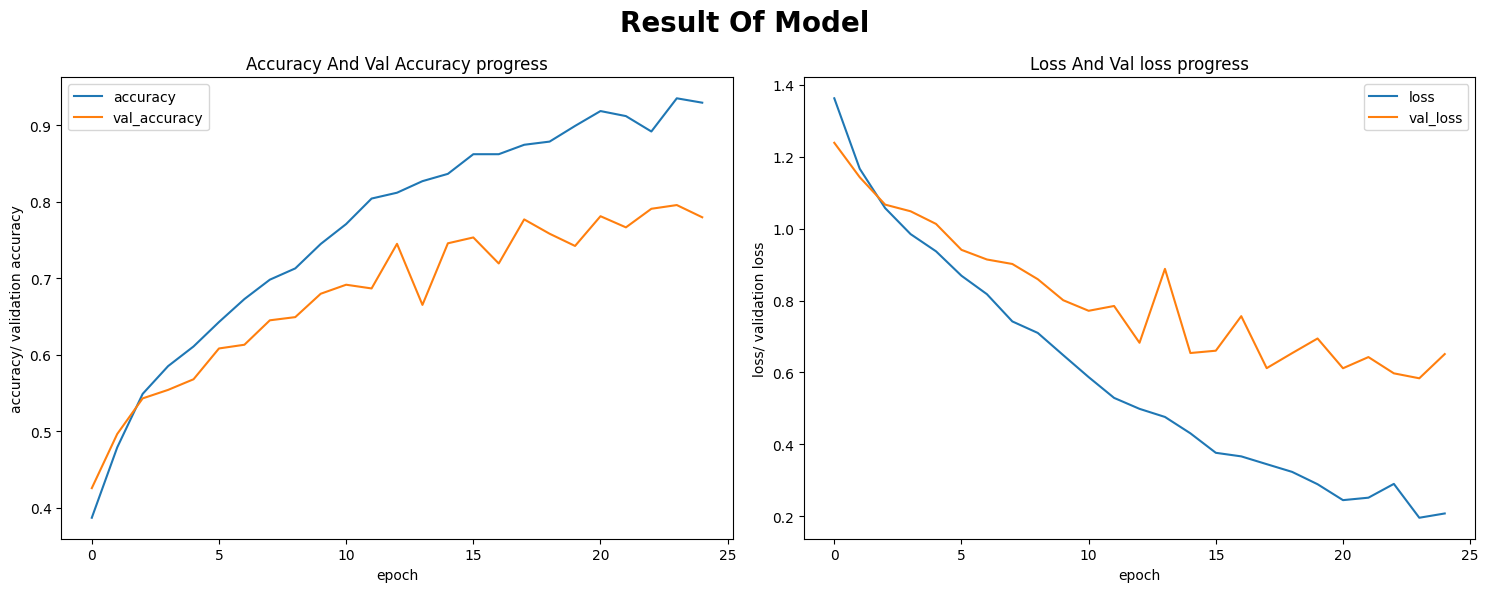

In [26]:
def Visualize_Result(acc,val_acc,loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6))

    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')

    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\Accuracy_Loss_figure_ResNet50.png')
    plt.tight_layout()
    plt.show()

visualize_result = Visualize_Result(h_model.history['accuracy'],h_model.history['val_accuracy'], h_model.history['loss'], h_model.history['val_loss'])

## 7. Cross Validation

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set early stopping criteria
pat = 5 
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

# Define the model checkpoint callback
model_checkpoint = ModelCheckpoint(r'D:\Users\RESA\Coding\Evaluasi\h_ResNet50.h5', verbose=1, save_best_only=True)

# Define a function to fit the model
def fit_and_evaluate(X_train, X_test, Y_train, Y_test, EPOCHS=20, BATCH_SIZE=32, model=model):
    results = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        callbacks=[early_stopping, model_checkpoint], verbose=1, validation_split=0.2)
    print("Val Score: ", model.evaluate(X_test, Y_test))
    return results

### 7.1 Training

In [28]:
n_folds = 5
epochs = 20
batch_size = 16

# Save the model history after fitting so that we can plot later
model_history = []

for i in range(n_folds):
    print("Training on Fold: ", i + 1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                                random_state=np.random.randint(1, 1000, 1)[0])
    model_history.append(fit_and_evaluate(X_train, X_test, Y_train, Y_test, epochs, batch_size))
    print("=======" * 12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
288/288 [==============================] - 204s 701ms/step - loss: 0.4090 - accuracy: 0.8487 - specificity: 0.9613 - sensitivity: 0.8229 - val_loss: 0.3577 - val_accuracy: 0.8724 - val_specificity: 0.9673 - val_sensitivity: 0.8507

Epoch 00001: val_loss improved from inf to 0.35771, saving model to D:\Users\RESA\Coding\Evaluasi\h_ResNet50.h5
Epoch 2/20
288/288 [==============================] - 201s 698ms/step - loss: 0.3463 - accuracy: 0.8735 - specificity: 0.9700 - sensitivity: 0.8457 - val_loss: 0.3057 - val_accuracy: 0.8950 - val_specificity: 0.9780 - val_sensitivity: 0.8681

Epoch 00002: val_loss improved from 0.35771 to 0.30571, saving model to D:\Users\RESA\Coding\Evaluasi\h_ResNet50.h5
Epoch 3/20
288/288 [==============================] - 199s 691ms/step - loss: 0.3206 - accuracy: 0.8796 - specificity: 0.9703 - sensitivity: 0.8568 - val_loss: 0.2754 - val_accuracy: 0.9080 - val_specificity: 0.9774 - val_sensitivity: 0.8819

Epoch 00003: val_loss 

### 7.2 Evaluasi Cross - Validation

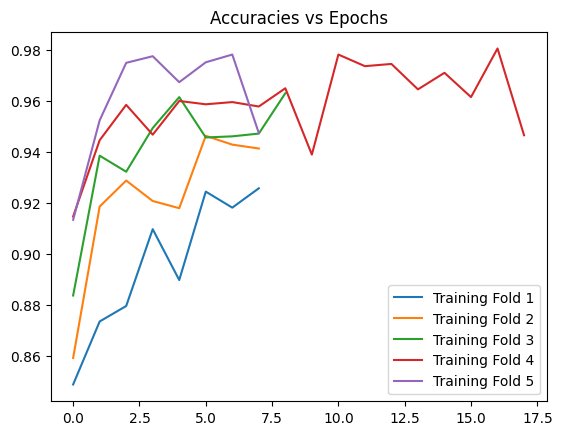

In [29]:
plt.title('Accuracies vs Epochs')
for i in range(len(model_history)):
  plt.plot(model_history[i].history['accuracy'], label=f"Training Fold {i+1}")

plt.legend()
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\Accuracy_vs_Epoch_ResNet50.png')

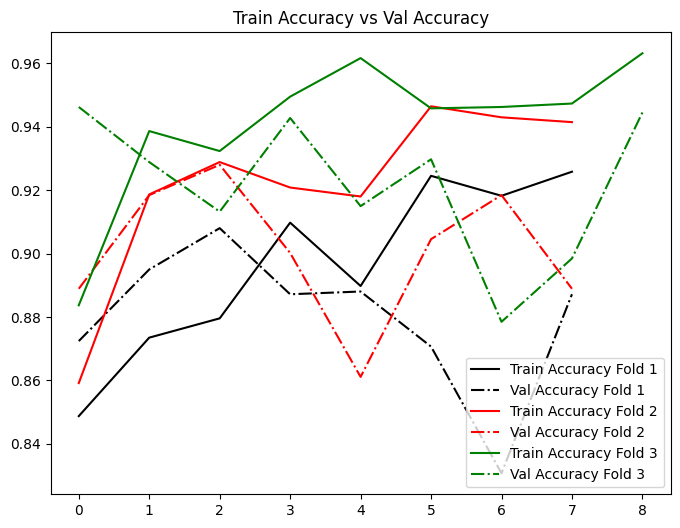

In [30]:
plt.figure(figsize=(8,6))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\TrainAccuracy_vs_ValAccuracy_Resnet50.png')

In [31]:
y_preds =  model.predict(X_test)
y_preds

array([[5.9119327e-05, 2.6420517e-05, 9.9991393e-01, 5.1674328e-07],
       [1.4263805e-03, 1.8430467e-01, 2.0300917e-01, 6.1125976e-01],
       [3.5367601e-04, 9.2892185e-07, 9.9960238e-01, 4.3052427e-05],
       ...,
       [1.5146327e-03, 7.0701898e-03, 1.1545499e-05, 9.9140364e-01],
       [9.9987805e-01, 9.2593289e-08, 4.2965961e-11, 1.2176819e-04],
       [9.9951339e-01, 4.8075430e-04, 4.2755272e-07, 5.3684621e-06]],
      dtype=float32)

In [32]:
y_preds_arg = np.argmax(y_preds,axis=1)
y_preds_arg

array([2, 3, 2, ..., 3, 0, 0], dtype=int64)

In [33]:
asd = np.argmax(Y_test, axis=1)
asd

array([2, 3, 2, ..., 3, 0, 0], dtype=int64)

In [34]:
confusion_matrix(asd,y_preds_arg)

array([[330,   7,   2,   4],
       [ 10, 320,   2,   1],
       [  9,  11, 345,   6],
       [ 15,  25,  15, 338]], dtype=int64)

In [35]:
print(classification_report(asd,y_preds_arg))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       343
           1       0.88      0.96      0.92       333
           2       0.95      0.93      0.94       371
           3       0.97      0.86      0.91       393

    accuracy                           0.93      1440
   macro avg       0.93      0.93      0.93      1440
weighted avg       0.93      0.93      0.93      1440



In [36]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,fmt='g', cmap="viridis")
    plt.show()

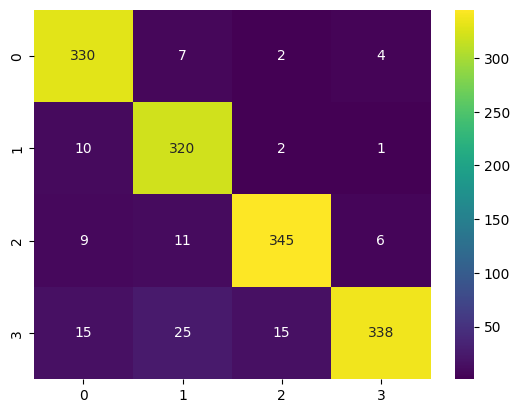

In [37]:
draw_confusion_matrix(asd,y_preds_arg)